Now that I played with that other catalog a bit (though there are still a lot of questions) I'm going to try to do some inference on it. I have 2 Catalogs I want to work with. The full one that I got from Eli/Risa is very long, with nearly 1.5 miliion rows. This is much longer than the one I snagged from Buzzard 1.0. I managed to snag a small subset of it. I'll develop and test it on the small one and I can maybe load up the large on at SLAC. 

In [227]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [228]:
from astropy.io import fits
dataDir = '/home/sean/Data/BuzzardSims/'
hdulist = fits.open(dataDir+'buzzard-v1.1-y5_run_00340_lambda_chisq.fit')
data = hdulist[1].data

In [229]:
data.columns.info()

name:
    ['HALOID', 'RA', 'DEC', 'Z', 'M200', 'R200', 'MEM_MATCH_ID', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E', 'LAMBDA_CHISQ_ZORIG', 'SCALEVAL', 'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'MASKFRAC', 'GEOMASKFRAC', 'R_LAMBDA', 'R_MASK', 'Z_LAMBDA', 'Z_LAMBDA_E', 'NCROSS', 'Z_LAMBDA_NITER', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ', 'DLAMBDAVAR_DZ2', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'PZBINS', 'PZ', 'Z_LAMBDA_RAW', 'Z_LAMBDA_E_RAW', 'P_BCG', 'BCG_SPEC_Z', 'LIM_EXPTIME', 'LIM_LIMMAG', 'LIM_LIMMAG_HARD']
format:
    ['J', 'D', 'D', 'E', 'D', 'D', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'I', 'I', 'E', 'E', 'E', 'E', 'E', '3E', '3E', '4E', '21E', '21E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
unit:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
null:
    ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

These catalogs are nice cuz they've been paired with their corresponding masses. However, there is the trouble that there's much less error than there would be in real life. 

76997
Mass V Richness


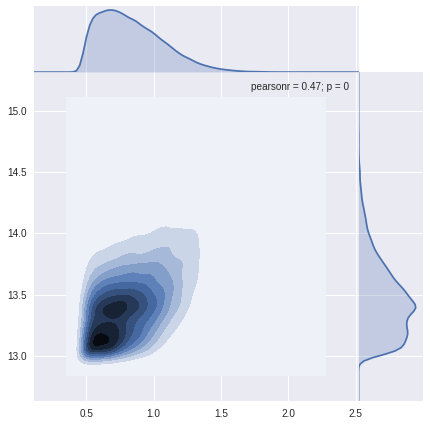

In [230]:
import numpy as np
mass = data['M200']
print mass.shape[0]
rich = data['LAMBDA_CHISQ']
mass = mass[rich>0]
rich = rich[rich>0]#slice off null values
logMass = np.log10(mass)
logRich = np.log10(rich)
print 'Mass V Richness'
sns.jointplot(logRich, logMass, kind = 'kde', space = 0)

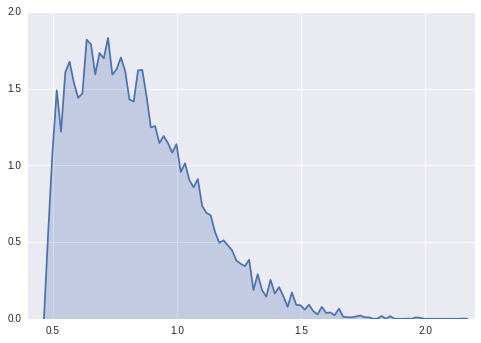

In [231]:
sns.kdeplot(logRich, shade = True, bw = .005)

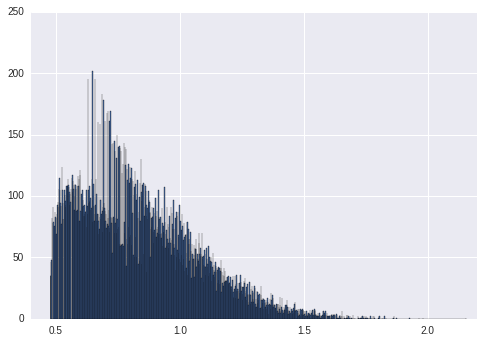

In [232]:
plt.hist(logRich, bins = 1000);

In [233]:
from scipy.stats import linregress
b, logA, r, p, err = linregress(logMass, logRich)
print 'a: %.3e\tb: %.3e'%(10**logA, b)
print 'R^2: %.3f'%r**2

a: 8.261e-05	b: 3.656e-01
R^2: 0.222


Those are some astronomy regression numbers right there. I'll see if I can use Bayes magic to improve on it. 

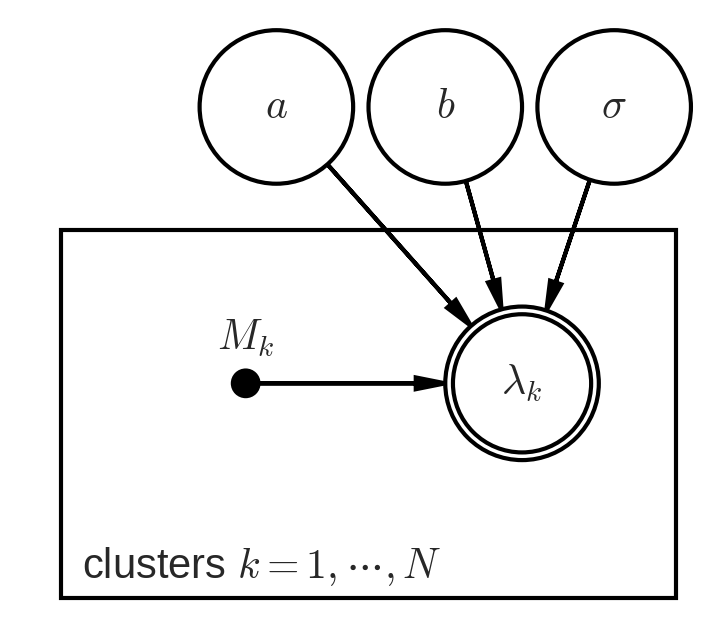

In [234]:
from IPython.display import Image
Image("modelPGM3.png")

This has the distribution:

$P(a,b,\sigma | \{M\}, \{\lambda\}) = \prod_{k=1}^N{P(\lambda_k |\; M_k, a,b,\sigma) P(a,b,\sigma)\;} $

In [235]:
from scipy.stats import gamma
def log_prior(a,b,sigma):
    
    #if any(x<0 for x in (a,sigma)):
    #    return -np.inf
    if sigma<0:
        return - np.inf
    t = np.arctan(b)
    if t<0 or t>np.pi/2:
        return -np.inf
    
    #Hyperparameters
    lambda_a = 1
    sigma_a, sigma_b = 1,1
    
    p = 0
    #Exponential in log a
    #p+= np.log(lambda_a)-lambda_a*np.log(a)
    p+= np.log(lambda_a)-lambda_a*a #changed a => logA TODO Change variable name?
    #Uniform in arctan(b)
    p+=np.log(2/np.pi)
    #Inv Gamma for sigma
    p-= gamma.logpdf(sigma,sigma_a, scale = sigma_b)
    return p

norms = {}
def log_liklihood(rich, M, a,b,sigma):
    p = 0

    #p-= np.sum(((b*np.log(M)+np.log(a)-np.log(rich))**2)/(2*sigma**2)+np.log(sigma*rich))
    p-= np.sum(((b*np.log(M)+a-np.log(rich))**2)/(2*sigma**2)+np.log(sigma*rich))#See Above
    return p

def log_posterior(theta,rich, M):
    #print theta
    a,b,sigma = theta[:]
    #a = a*1e-11 #rescale
    p = log_prior(a,b,sigma)
    if np.isfinite(p):
        p+=log_liklihood(rich,M,a,b,sigma)
    #print '-'*50
    return p

In [236]:
ndim = 3
nwalkers = 1000

#a_log_mean, a_log_spread = -5, 2
#TODO ReDefine a as Log A?
a_mean, a_spread = -5, 2
b_mean, b_spread = 1, .5
sigma_mean, sigma_spread = 1, .5

pos0 = np.zeros((nwalkers, ndim))
for row in pos0:
    #a,b,sigma,m
    #a_try = -1
    #while a_try < 0:
        #a_try = 10**(a_log_mean+np.random.randn()*a_log_spread)
    #    a_try = a_mean+np.random.randn()*a_spread
    #row[0] = a_try
    row[0] = a_mean+np.random.randn()*a_spread
    row[1] = b_mean+np.random.randn()*b_spread
    sig_try = -1
    while sig_try < 0:
        sig_try = sigma_mean+np.random.randn()*sigma_spread
    row[2] = sig_try

In [237]:
import emcee as mc
import multiprocessing
nCores = multiprocessing.cpu_count()
sampler = mc.EnsembleSampler(nwalkers, ndim, log_posterior, args=[rich, mass],threads = nCores)
nsteps, nburn = 110, nwalkers*10

In [238]:
np.random.seed(0)#"random"

sampler.run_mcmc(pos0, nsteps);

In [239]:
chain = sampler.flatchain[nburn:, :]
#chain = sampler.chain
#chain = chain[:, nburn:, :].reshape((-1, ndim))
#print chain.shape
sampler.pool.terminate()#there's a bug in emcee that creates daemon threads. This kills them.
#del(sampler)

MAP = chain.mean(axis = 0)
print MAP

[-7.31315244  0.37700334  0.80258356]


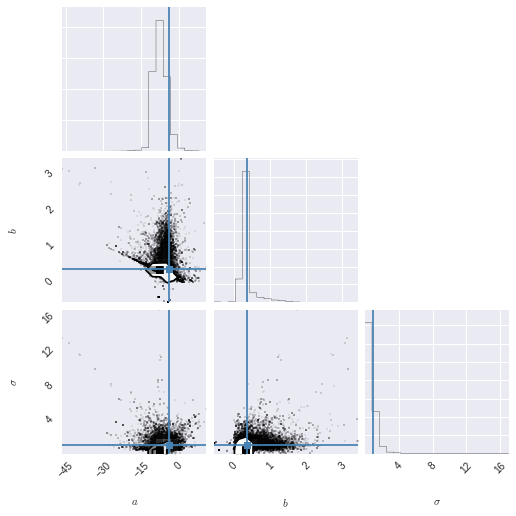

In [240]:
from corner import corner
titles = ['$a$', '$b$', '$\sigma$']
sigma_true = 1 #just a guess so this will plot
corner(chain, labels = titles , truths = [logA, b, sigma_true]);

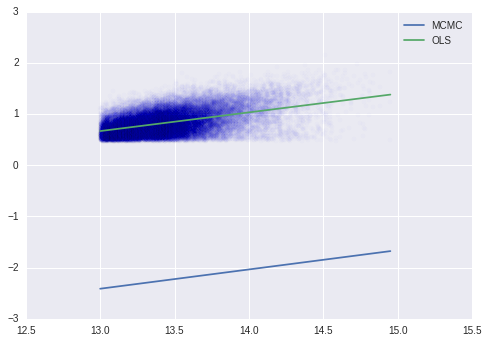

In [241]:
plt.scatter(logMass, logRich, alpha = .01)
plt.plot(logMass, MAP[1]*logMass+MAP[0], label = 'MCMC')
plt.plot(logMass, b*logMass+logA, label = 'OLS')
plt.legend(loc= 'best')

In [242]:
print MAP[0], logA
print MAP[1], b

-7.31315243805 -4.0829846203
0.377003343541 0.365623928309


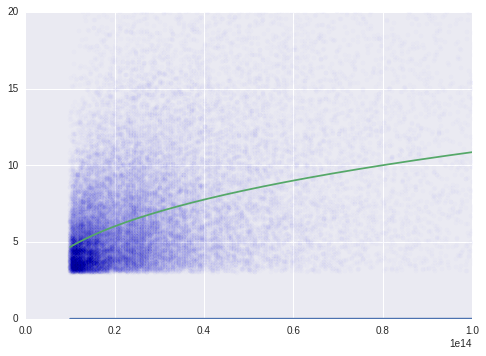

In [250]:
plt.scatter(mass, rich, alpha = .01)
plt.plot(mass, (10**MAP[0])*pow(mass, MAP[1]))
plt.plot(mass, (10**logA)*pow(mass, b))
plt.xlim([0,1e14]);
plt.ylim([0, 20]);

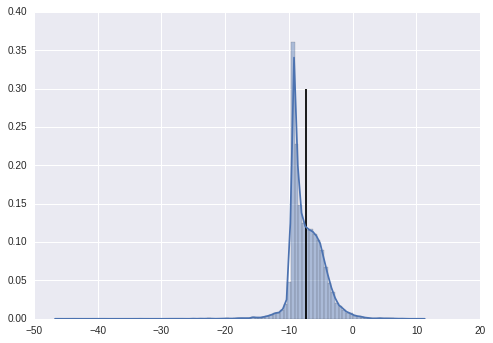

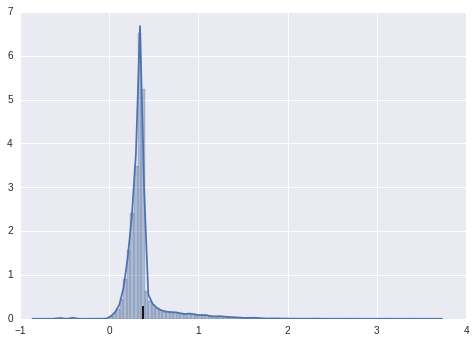

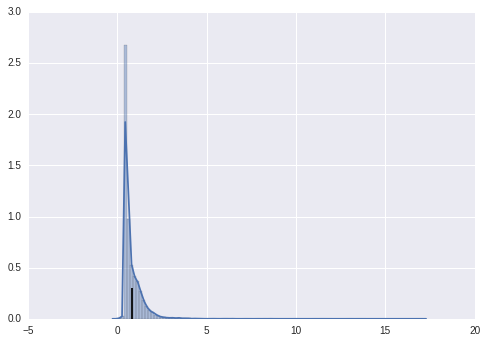

In [247]:
for i in xrange(3):
    sns.distplot(chain[:,i], bins = 100)
    plt.vlines(MAP[i], 0, .3)
    plt.show()